In [1]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from thesispy.experiments.dataset import FinishedRun, Dataset

plt.style.use(["science", "high-vis", "../resources/plt_custom.txt"])
api = wandb.Api(timeout=30)
entity = "joasiee"
DEFAULT_WIDTH = 485


def parse_run(run):
    return FinishedRun(
        run.name, run.config, pd.DataFrame.from_dict(run.scan_history())
    )

def get_runs_as_dataset(project, filters={}):
    runs = []
    for run in api.runs(entity + "/" + project, filters=filters):
        runs.append(parse_run(run))
    return Dataset(project, runs)

In [32]:
sampling_ds = Dataset.load("sampling_experiment2")
asgd_sampling = sampling_ds.filter("Optimizer == 'AdaptiveStochasticGradientDescent'")
gomeafull_sampling = sampling_ds.filter("Optimizer == 'GOMEA' AND NOT PartialEvaluations")
gomeapartial_sampling = sampling_ds.filter("Optimizer == 'GOMEA' AND PartialEvaluations")

In [39]:
groups = []
final_evals = []

for group, runs in gomeapartial_sampling.groupby(["SamplingPercentage"]):
    groups.append(group[0])
    evals = []
    for run in runs:
        evals.append(run.resolutions_train[0]["R0/metric"].values[-3])
    if len(runs) == 4:
        evals.append(np.mean(evals))
    final_evals.append(evals)

groups = [np.around(group,2) for group in groups]
groups, final_evals = zip(*sorted(zip(groups, final_evals)))
gomeapartial_df = pd.DataFrame(np.array(final_evals).transpose(), columns=groups)
gomeapartial_df["Optimizer"] = "GOMEA-partial"

In [40]:
frames = [gomeapartial_df]
sampling_df = pd.concat(frames)
boxplot_df = pd.melt(sampling_df, id_vars=["Optimizer"], var_name="SamplingPercentage", value_name="MSE")

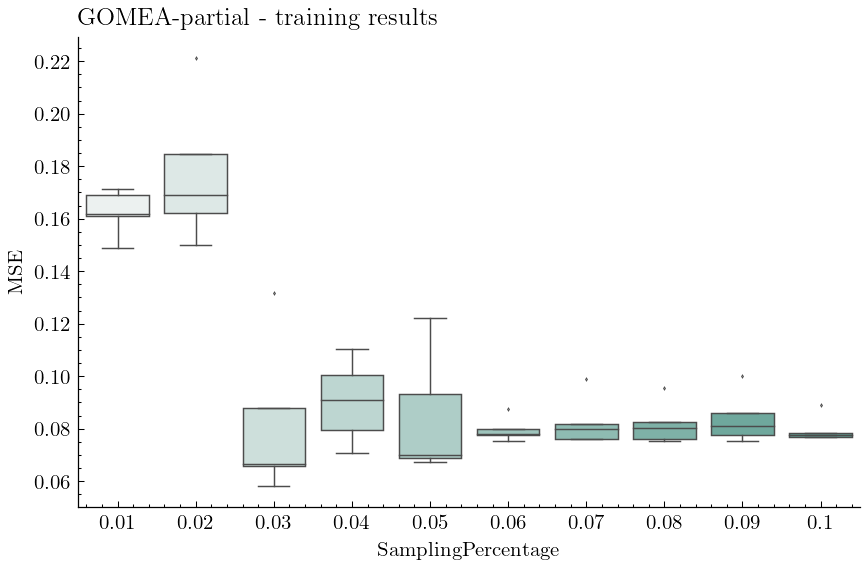

In [43]:
sns.boxplot(x="SamplingPercentage", y="MSE", data=boxplot_df, linewidth=0.7, fliersize=0.25, palette="light:#5A9")
plt.title("GOMEA-partial - training results")
plt.savefig("sampling_boxplot_gpartial_training.png")
plt.savefig("sampling_boxplot_gpartial_training.pdf")

In [49]:
def final_full_diff(ds, title):
    groups = []
    final_evals = []

    for group, runs in ds.groupby(["SamplingPercentage"]):
        groups.append(group[0])
        evals = []
        for run in runs:
            evals.append(run.resolutions_val[0]["R0/metric"] - run.resolutions_train[0]["R0/metric"].values[-3])
        if len(runs) == 4:
            evals.append(np.mean(evals))
        final_evals.append(evals)

    groups = [np.around(group,2) for group in groups]
    groups, final_evals = zip(*sorted(zip(groups, final_evals)))
    df = pd.DataFrame(np.array(final_evals).transpose(), columns=groups)
    df["Optimizer"] = title
    return df

In [ ]:
sampling_shuffle_less = get_runs_as_dataset("sampling_experiment_shuffle2")

In [50]:
frames = [
    final_full_diff(asgd_sampling, "ASGD"),
    final_full_diff(gomeafull_sampling, "GOMEA-full"),
    final_full_diff(gomeapartial_sampling, "GOMEA-partial"),
    final_full_diff(sampling_shuffle_less, "GOMEA-partial+shuffle")
]
diff_df = pd.concat(frames)
boxplot_df = pd.melt(
    diff_df,
    var_name="SamplingPercentage",
    value_name="MSE Difference",
    id_vars=["Optimizer"],
)
boxplot_df = boxplot_df[["Optimizer", "MSE Difference"]]


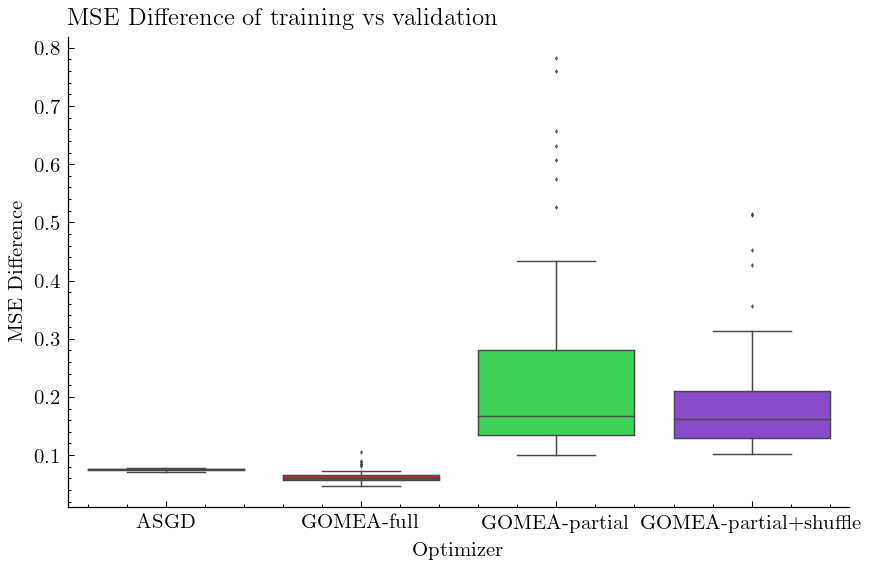

In [51]:
sns.boxplot(x="Optimizer", y="MSE Difference", data=boxplot_df, linewidth=0.7, fliersize=0.25)
plt.title("MSE Difference of training vs validation")
plt.savefig("sampling_diffs2.png")
plt.savefig("sampling_diffs2.pdf")

In [8]:
sampling_shuffle = get_runs_as_dataset("sampling_experiment_shuffle", {"state": "finished", "config.SamplingPercentage": 0.05})

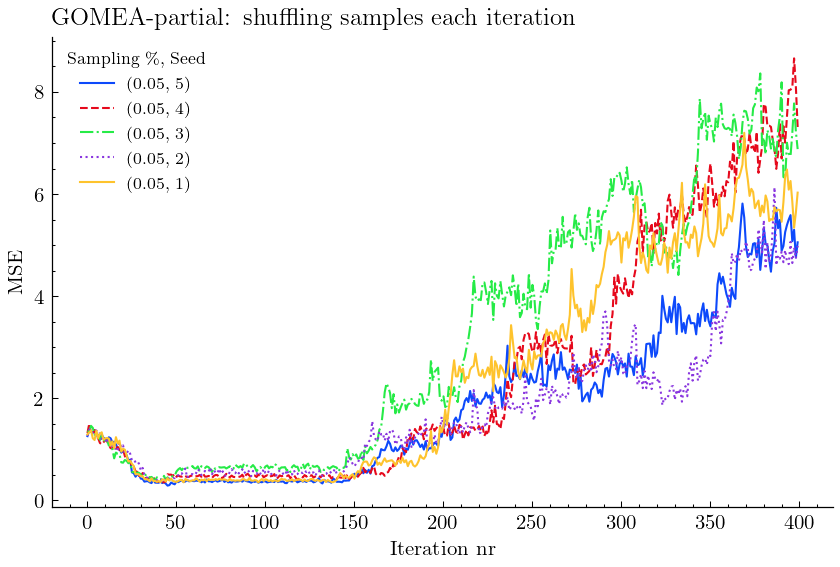

In [47]:
ys = [run.resolutions_train[0] for run in sampling_shuffle.runs]
labels = [(run.config["SamplingPercentage"], run.config["RandomSeed"]) for run in sampling_shuffle.runs]
for i, y in enumerate(ys):
    plt.plot(y["_step"], y["R0/metric"], label=labels[i])

plt.xlabel("Iteration nr")
plt.ylabel("MSE")
plt.title("GOMEA-partial: shuffling samples each iteration")
plt.legend(title="Sampling \%, Seed", fontsize=8, title_fontsize=8)
plt.savefig("sampling_shuffle_convergence.pdf")
plt.savefig("sampling_shuffle_convergence.png")

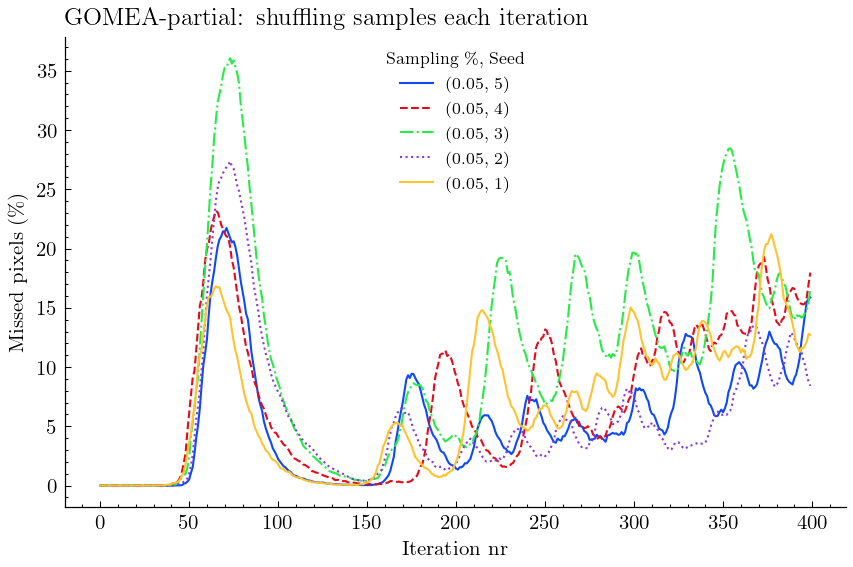

In [48]:
for i, y in enumerate(ys):
    plt.plot(y["_step"], y["R0/missedpixels"], label=labels[i])

plt.xlabel("Iteration nr")
plt.ylabel("Missed pixels (\%)")
plt.title("GOMEA-partial: shuffling samples each iteration")
plt.legend(title="Sampling \%, Seed", fontsize=8, title_fontsize=8)
plt.savefig("sampling_shuffle_missedpixels.pdf")
plt.savefig("sampling_shuffle_missedpixels.png")